In [1]:
import os

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import time

import matplotlib.pyplot as plt


2024-07-30 08:17:09.172828: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-30 08:17:10.627266: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 08:17:10.627296: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 08:17:10.633381: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-30 08:17:11.137157: I tensorflow/core/platform/cpu_feature_g

# Synthetic Data

In [2]:
n = 5000

X_ij    = tf.convert_to_tensor(np.load("data/synthetic/synth_X_ij_"+str(n)+".npy"), dtype = tf.int32)
one_n_j = tf.convert_to_tensor(np.load("data/synthetic/NY_one_n_j.npy"), dtype = tf.float32)

2024-07-29 22:01:35.158290: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-29 22:01:35.590110: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-29 22:01:35.590145: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-29 22:01:35.598891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-29 22:01:35.598929: I tensorflow/compile

# HDP with Monta Carlo/sampling

Set seed and parameters

In [3]:
seed_to_use = 123+n

tf.random.set_seed((seed_to_use+n))
np.random.seed((seed_to_use+n))

K_initial = 100
K_max = 2*K_initial

a_0, b_0 = 2., 1.
a_1, b_1 = 2., 1. 
a_2, b_2 = 1., 1. 
sigma = 0.1

prior_MCMC = a_0, b_0, a_1, b_1, a_2, b_2, sigma

batch_size = 2**11
N = 712174

MCMC_iterations = 100

In [4]:
os.chdir("scripts/")
%run -i BNP.py
os.chdir("../")

Run 2000 iterations of the MCMC (it might take more than 5min)

In [5]:
seed_MCMC_start, seed_MCMC_after_start  = tfp.random.split_seed( seed_to_use, n=2, salt='seed_MCMC_start_'+str(n))

output = BNP_MCMC_from_start(X_ij, one_n_j, K_initial, K_max, prior_MCMC, MCMC_iterations, seed_MCMC_start, "multiple", "fixed a,b")

initialization_MCMC = tuple(elem[-1,...] for elem in output)

seed_MCMC_before_tau, seed_MCMC_after_tau  = tfp.random.split_seed( seed_MCMC_after_start, n=2, salt='seed_MCMC_before_after_tau_'+str(n))

before_tau_iterations = 19
seed_MCMC_before_tau_splitted  = tfp.random.split_seed( seed_MCMC_before_tau, n=before_tau_iterations, salt='seed_MCMC_before_tau_'+str(n))
for i in range(before_tau_iterations):

    print("Batch number "+str(i))

    output = BNP_MCMC_initialized(X_ij, one_n_j, K_max, prior_MCMC, initialization_MCMC, MCMC_iterations, seed_MCMC_before_tau_splitted[i], "multiple", "fixed a,b")
    initialization_MCMC = tuple(elem[-1,...] for elem in output)

2024-07-29 22:01:36.267992: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-29 22:01:39.068057: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xa835f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-29 22:01:39.068094: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-07-29 22:01:39.076609: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-29 22:01:39.153295: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907

2024-07-29 22:01:39.781132: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-07-29 22:01:55.792906:

Batch number 0
Batch number 1
Batch number 2
Batch number 3
Batch number 4
Batch number 5
Batch number 6
Batch number 7
Batch number 8
Batch number 9
Batch number 10
Batch number 11
Batch number 12
Batch number 13
Batch number 14
Batch number 15
Batch number 16
Batch number 17
Batch number 18


Change _"Monte Carlo"_ to _"sampling"_ in _BNP_MCMC_initialized_tau_ if you want to use sampling to estimate $\tau$. Remark that using sampling is significantly slower! It might take more than 1min to run.

In [6]:

after_tau_iterations = 5
seed_MCMC_after_tau_splitted  = tfp.random.split_seed( seed_MCMC_after_tau, n=after_tau_iterations, salt='seed_MCMC_after_tau_'+str(n))
for i in range(after_tau_iterations):
    
    print("Tau Batch number "+str(i))

    tau_output = BNP_MCMC_initialized_tau(X_ij, one_n_j, K_max, prior_MCMC, initialization_MCMC, N, MCMC_iterations, batch_size, seed_MCMC_after_tau_splitted[i], "multiple", "fixed a,b", "Monte Carlo")
    initialization_MCMC = tuple(elem[-1,...] for elem in tau_output[0])



    


Tau Batch number 0
Tau Batch number 1
Tau Batch number 2
Tau Batch number 3
Tau Batch number 4


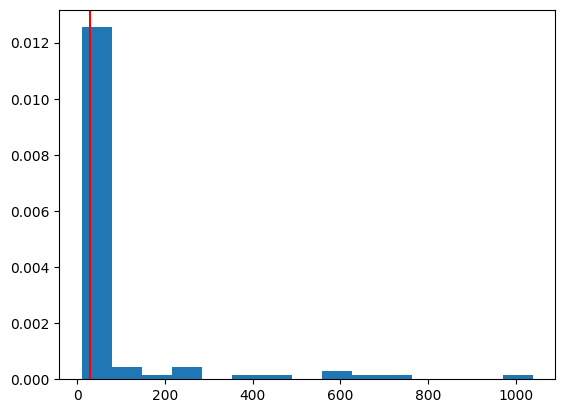

In [16]:
plt.hist(tau_output[1], 15, density = True)
plt.axvline(x = 28, color = "red")

# Algorithm from Manrique-Vallier and Reiter 2012

In [8]:
os.chdir("scripts/")
%run -i MVR.py
os.chdir("../")

In [9]:
a_0, b_0 = 2, 1

K = 2

sigma = 0.095
batch_size = 2**13
N = 1150934

MCMC_iterations = 100

seed_to_use = 123+n

tf.random.set_seed((seed_to_use+n))
np.random.seed((seed_to_use+n))

Run the algorithm from Manrique-Vallier and Reiter 2012. It might take more than 5min.

In [10]:
MCMC_Z_ij_init, MCMC_theta_j_k_init, MCMC_g_i_init, MCMC_g_0_init, nr_accepted_init = MVR_MCMC_from_start(X_ij, one_n_j, K, a_0, b_0, sigma, MCMC_iterations, seed_MCMC_start)
initialization_MCMC = MCMC_Z_ij_init[-1,...], MCMC_theta_j_k_init[-1,...], MCMC_g_i_init[-1,...], MCMC_g_0_init[-1,...], nr_accepted_init[-1,...]

seed_MCMC_before_tau, seed_MCMC_after_tau  = tfp.random.split_seed( seed_MCMC_after_start, n=2, salt='seed_MCMC_before_after_tau_'+str(n)+str(0))

before_tau_iterations = 19
seed_MCMC_before_tau_splitted  = tfp.random.split_seed( seed_MCMC_before_tau, n=before_tau_iterations, salt='seed_MCMC_before_tau_'+str(n)+str(0))
for i in range(before_tau_iterations):

    print("Batch number "+str(i))

    MCMC_Z_ij, MCMC_theta_j_k, MCMC_g_i, MCMC_g_0, nr_accepted = MVR_MCMC_initialized(X_ij, one_n_j, K, a_0, b_0, sigma, initialization_MCMC, MCMC_iterations, seed_MCMC_before_tau_splitted[i])
    initialization_MCMC = MCMC_Z_ij[-1,...], MCMC_theta_j_k[-1,...], MCMC_g_i[-1,...], MCMC_g_0[-1,...], nr_accepted[-1,...]

after_tau_iterations = 5
seed_MCMC_after_tau_splitted  = tfp.random.split_seed( seed_MCMC_after_tau, n=after_tau_iterations, salt='seed_MCMC_after_tau_'+str(n))
for i in range(after_tau_iterations):
    
    print("Tau Batch number "+str(i))
    
    (MCMC_Z_ij, MCMC_theta_j_k, MCMC_g_i, MCMC_g_0, nr_accepted), tau = MVR_MCMC_initialized_tau(X_ij, one_n_j, K, a_0, b_0, sigma, initialization_MCMC, N, MCMC_iterations, batch_size, seed_MCMC_after_tau_splitted[i])
    initialization_MCMC = MCMC_Z_ij[-1,...], MCMC_theta_j_k[-1,...], MCMC_g_i[-1,...], MCMC_g_0[-1,...], nr_accepted[-1,...]

Batch number 0
Batch number 1
Batch number 2
Batch number 3
Batch number 4
Batch number 5
Batch number 6
Batch number 7
Batch number 8
Batch number 9
Batch number 10
Batch number 11
Batch number 12
Batch number 13
Batch number 14
Batch number 15
Batch number 16
Batch number 17
Batch number 18
Tau Batch number 0
Tau Batch number 1
Tau Batch number 2
Tau Batch number 3
Tau Batch number 4


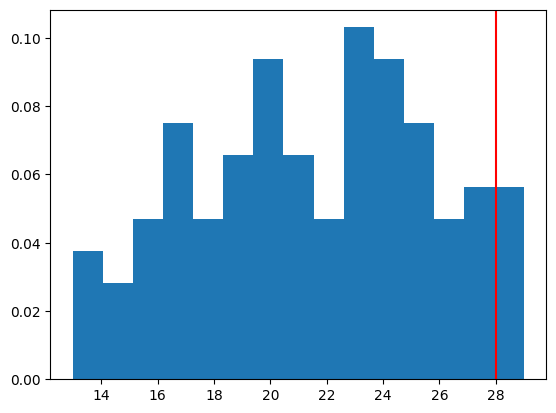

In [15]:
plt.hist(tau, 15, density = True)
plt.axvline(x = 28, color = "red")

# Real data: HDP without structural zeros adjustment

In [3]:
n = 5000

seed_to_use = 42+n

tf.random.set_seed((seed_to_use+n))
np.random.seed((seed_to_use+n))

K_initial = 100
K_max = 2*K_initial

a_0, b_0 = 2., 1.
a_1, b_1 = 2., 1. 
a_2, b_2 = 1., 1. 
sigma = 0.1

prior_MCMC = a_0, b_0, a_1, b_1, a_2, b_2, sigma

X_ij    = tf.convert_to_tensor(np.load("data/structural_zeros/SZ_NY_X_ij_"+str(n)+".npy"), dtype = tf.int32)
one_n_j = tf.convert_to_tensor(np.load("data/structural_zeros/SZ_NY_one_n_j.npy"), dtype = tf.float32)

batch_size = 100
N = 953076

MCMC_iterations = 100

In [5]:
os.chdir("scripts/")
%run -i BNP.py
os.chdir("../")

It might take more than 5min

In [6]:
seed_MCMC_start, seed_MCMC_after_start  = tfp.random.split_seed( seed_to_use, n=2, salt='seed_MCMC_start_'+str(n))

output = BNP_MCMC_from_start(X_ij, one_n_j, K_initial, K_max, prior_MCMC, MCMC_iterations, seed_MCMC_start, "multiple", "fixed a,b")

initialization_MCMC = tuple(elem[-1,...] for elem in output)

seed_MCMC_before_tau, seed_MCMC_after_tau  = tfp.random.split_seed( seed_MCMC_after_start, n=2, salt='seed_MCMC_before_after_tau_'+str(n))

before_tau_iterations = 19
seed_MCMC_before_tau_splitted  = tfp.random.split_seed( seed_MCMC_before_tau, n=before_tau_iterations, salt='seed_MCMC_before_tau_'+str(n))
for i in range(before_tau_iterations):

    print("Batch number "+str(i))

    output = BNP_MCMC_initialized(X_ij, one_n_j, K_max, prior_MCMC, initialization_MCMC, MCMC_iterations, seed_MCMC_before_tau_splitted[i], "multiple", "fixed a,b")
    initialization_MCMC = tuple(elem[-1,...] for elem in output)



after_tau_iterations = 5
seed_MCMC_after_tau_splitted  = tfp.random.split_seed( seed_MCMC_after_tau, n=after_tau_iterations, salt='seed_MCMC_after_tau_'+str(n))
for i in range(after_tau_iterations):
    
    print("Tau Batch number "+str(i))

    tau_output = BNP_MCMC_initialized_tau(X_ij, one_n_j, K_max, prior_MCMC, initialization_MCMC, N, MCMC_iterations, batch_size, seed_MCMC_after_tau_splitted[i], "multiple", "fixed a,b", "Monte Carlo")
    initialization_MCMC = tuple(elem[-1,...] for elem in tau_output[0])

2024-07-30 08:41:06.496430: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-30 08:41:09.852934: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xb544b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-30 08:41:09.853003: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-07-30 08:41:09.887768: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-30 08:41:10.017323: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907

2024-07-30 08:41:11.009773: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-07-30 08:41:26.599693:

Batch number 0
Batch number 1
Batch number 2
Batch number 3
Batch number 4
Batch number 5
Batch number 6
Batch number 7
Batch number 8
Batch number 9
Batch number 10
Batch number 11
Batch number 12
Batch number 13
Batch number 14
Batch number 15
Batch number 16
Batch number 17
Batch number 18
Tau Batch number 0
Tau Batch number 1
Tau Batch number 2
Tau Batch number 3
Tau Batch number 4


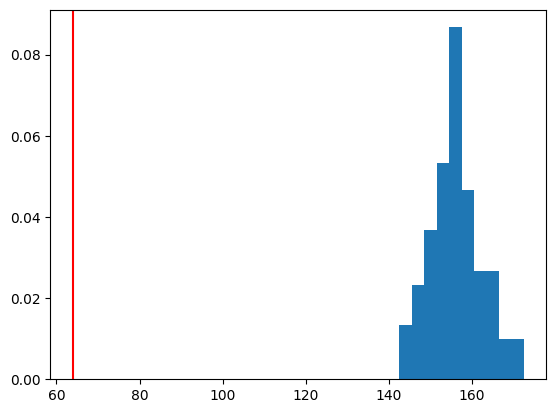

In [8]:
plt.hist(tau_output[1], 10, density = True)
plt.axvline(x = 64, color = "red")

# Real data: HDP with structural zeros adjustment

In [11]:
seed_to_use = 1234

tf.random.set_seed((seed_to_use+n))
np.random.seed((seed_to_use+n))

K_initial = 50
K_max = 4*K_initial

a_0, b_0 = 2., 1.
a_1, b_1 = 2., 1. 
a_2, b_2 = 1., 1. 
sigma = 0.1

prior_MCMC = a_0, b_0, a_1, b_1, a_2, b_2, sigma

disjoint_constraint = tf.convert_to_tensor(np.load("data/structural_zeros/SZ_NY_disjoint_constraint.npy"), dtype = tf.int32)
disjoint_constraints = disjoint_constraint -1 

batch_size = 100
N = 953076

MCMC_iterations = 100

seed_MCMC_start, seed_MCMC_after_start  = tfp.random.split_seed( seed_to_use, n=2, salt='seed_MCMC_start_'+str(n))

In [12]:
os.chdir("scripts/")
%run -i BNP_structural_zeros.py
os.chdir("../")

It might take more than 10min

In [13]:
output = SZ_BNP_MCMC_from_start(X_ij, disjoint_constraints, one_n_j, K_initial, K_max, prior_MCMC, MCMC_iterations, seed_MCMC_start, "multiple", "fixed a,b")
initialization_MCMC = tuple(elem[-1,...] for elem in output)

seed_MCMC_before_tau, seed_MCMC_after_tau  = tfp.random.split_seed( seed_MCMC_after_start, n=2, salt='seed_MCMC_before_after_tau_'+str(n))

before_tau_iterations = 19
seed_MCMC_before_tau_splitted  = tfp.random.split_seed( seed_MCMC_before_tau, n=before_tau_iterations, salt='seed_MCMC_before_tau_'+str(n))
for i in range(before_tau_iterations):

    print("Batch number "+str(i))

    output = SZ_BNP_MCMC_initialized(X_ij, disjoint_constraints, one_n_j, K_max, prior_MCMC, initialization_MCMC, MCMC_iterations, seed_MCMC_before_tau_splitted[i], "multiple", "fixed a,b")
    initialization_MCMC = tuple(elem[-1,...] for elem in output)

after_tau_iterations = 5
seed_MCMC_after_tau_splitted  = tfp.random.split_seed( seed_MCMC_after_tau, n=after_tau_iterations, salt='seed_MCMC_after_tau_'+str(n))
for i in range(after_tau_iterations):
    
    print("Tau Batch number "+str(i))

    tau_output = SZ_BNP_MCMC_initialized_tau(X_ij, disjoint_constraints, one_n_j, K_max, prior_MCMC, 
					  initialization_MCMC, MCMC_iterations, N, batch_size, 
                			  seed_MCMC_after_tau_splitted[i], "multiple", "fixed a,b", "Monte Carlo")
    
    initialization_MCMC = tuple(elem[-1,...] for elem in tau_output[0])

2024-07-30 08:47:51.088172: W tensorflow/compiler/tf2xla/kernels/categorical_op.cc:130] Warning: Using tf.random.categorical with XLA compilation will ignore seeds.



Batch number 0
Batch number 1
Batch number 2
Batch number 3
Batch number 4
Batch number 5
Batch number 6
Batch number 7
Batch number 8
Batch number 9
Batch number 10
Batch number 11
Batch number 12
Batch number 13
Batch number 14
Batch number 15
Batch number 16
Batch number 17
Batch number 18
Tau Batch number 0
Tau Batch number 1
Tau Batch number 2
Tau Batch number 3
Tau Batch number 4


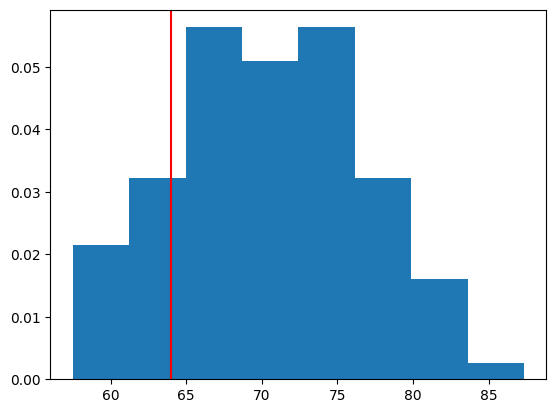

In [15]:
plt.hist(tau_output[1], 8, density = True)
plt.axvline(x = 64, color = "red")

Detailed experiments are provided in the folder _experiments_